<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">

**Project Description:**

This notebook contains a machine learning model developed to predict smoking behavior.
Since smoking has significant effects on health, the goal of this project is to create a model capable of predicting smoking behavior.

**Dataset Description:**

The utilized dataset includes various features that may influence smoking behavior.
Several analyses have been conducted to understand the relationships between variables and evaluate the performance of the model.

**Machine Learning Model:**

The model used in this project is trained using [LGBM / XGB].
<p style="background-color:#000000; font-family:'Courier New', monospace; color:#602F44; font-size:150%; text-align:center; padding: 10px; border-radius:


<p style="background-color:#2E2E2E; font-family:'Courier New', monospace; color:#00FFFF; font-size:160%; text-align:center; padding: 10px; border-radius: 20px;"> 📖 Reading and Cleaning 🧹 </p>

In [83]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_validate,cross_val_score

In [43]:
path = "/kaggle/input/playground-series-s3e24/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")
sub = pd.read_csv(path+"sample_submission.csv")

In [44]:
train.drop("id",axis=1, inplace=True)
test.drop("id",axis=1, inplace=True)

In [45]:
train.head()

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  \
0   55         165          60       81.0             0.5              0.6   
1   70         165          65       89.0             0.6              0.7   
2   20         170          75       81.0             0.4              0.5   
3   35         180          95      105.0             1.5              1.2   
4   30         165          60       80.5             1.5              1.0   

   hearing(left)  hearing(right)  systolic  relaxation  ...  HDL  LDL  \
0              1               1       135          87  ...   40   75   
1              2               2       146          83  ...   57  126   
2              1               1       118          75  ...   45   93   
3              1               1       131          88  ...   38  102   
4              1               1       121          76  ...   44   93   

   hemoglobin  Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  \
0        16.5              1               1.0   22   25   27              0   
1        16.2              1               1.1   27   23   37              1   
2        17.4              1               0.8   27   31   53              0   
3        15.9              1               1.0   20   27   30              1   
4        15.4              1               0.8   19   13   17              0   

   smoking  
0        1  
1        0  
2        1  
3        0  
4        1  

[5 rows x 23 columns]

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:150%; text-align:left;padding: 0px;">Cleaning</p>

In [46]:
train.columns = train.columns.str.replace(" ","_")
test.columns = test.columns.str.replace(" ","_")

In [47]:
train.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting_blood_sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine_protein          0
serum_creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental_caries          0
smoking                0
dtype: int64

In [48]:
num_cols = [col for col in train.columns if (train[col].dtype in ["int64","float64"]) & (train[col].nunique()>10)]
num_cols

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'systolic',
 'relaxation',
 'fasting_blood_sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'serum_creatinine',
 'AST',
 'ALT',
 'Gtp']

In [49]:
cat_cols = [col for col in train.columns if train[col].nunique()<10]
cat_cols

['hearing(left)',
 'hearing(right)',
 'Urine_protein',
 'dental_caries',
 'smoking']

In [50]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
check_outlier(train, num_cols)

True

In [51]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(train, col)

In [52]:
check_outlier(train, num_cols)

False

<p style="background-color:#2E2E2E; font-family:'Courier New', monospace; color:#FFD700; font-size:160%; text-align:center; padding: 10px; border-radius: 20px;"> 📊 Exploratory Data Analysis (EDA) 📊 </p>


<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:150%; text-align:left;padding: 0px;">Categorical</p>

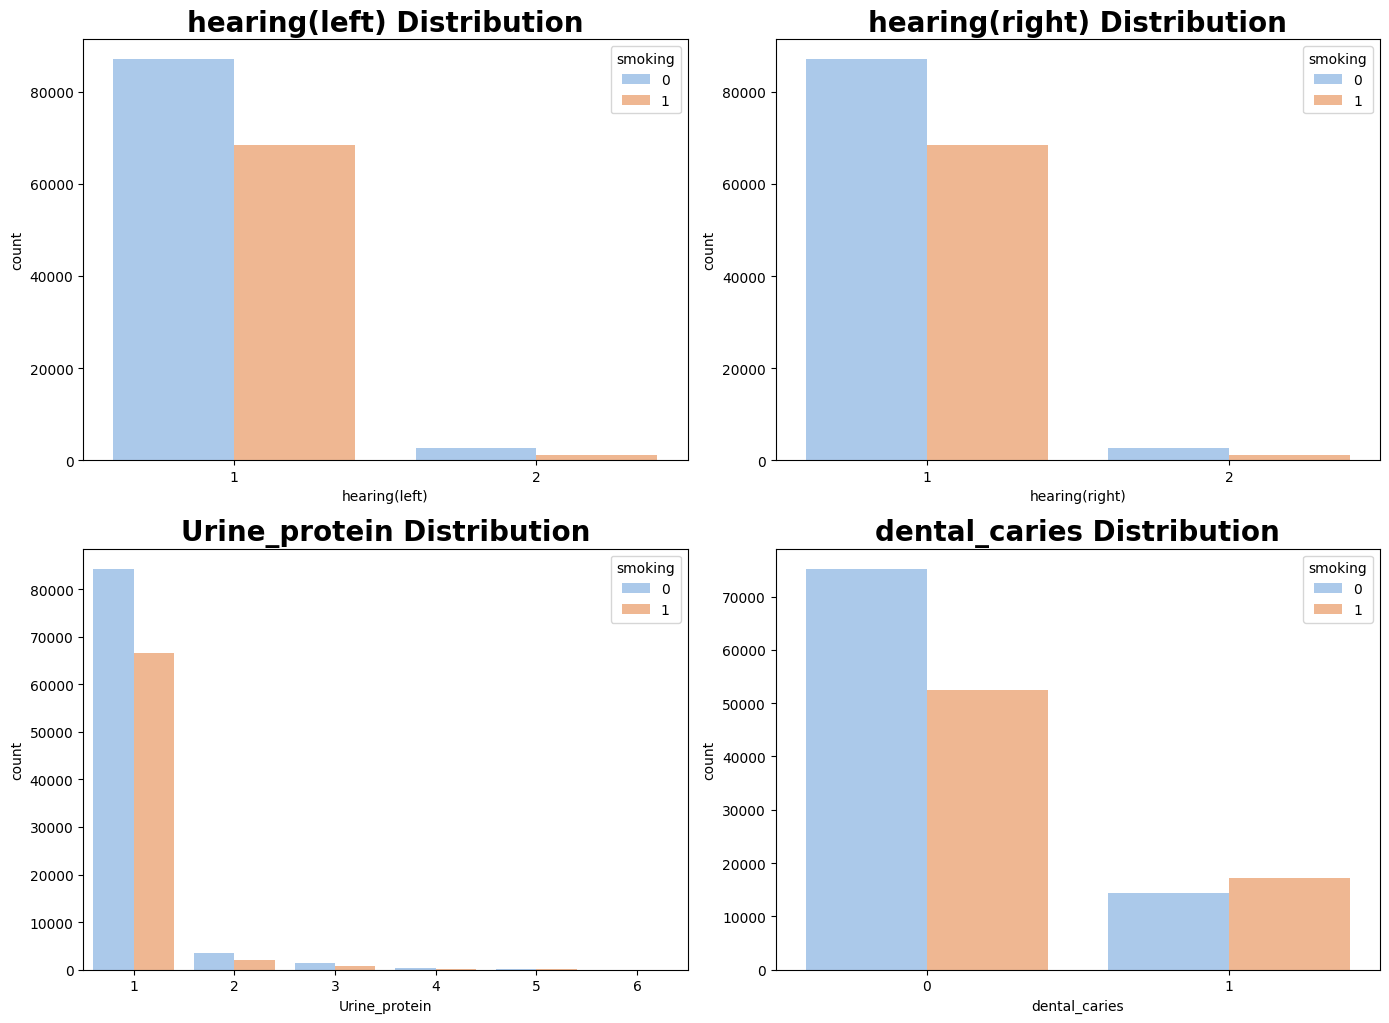

In [57]:
plt.figure(figsize=(14,len(cat_cols)*3))
for idx,column in enumerate(cat_cols[:-1]):
    plt.subplot(len(cat_cols)//2+1,2,idx+1)
    sns.countplot(hue="smoking", x=column, data=train, palette="pastel")
    plt.title(f"{column} Distribution",weight='bold',fontsize=20)
    plt.tight_layout()


<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:150%; text-align:left;padding: 0px;">Numerical</p>

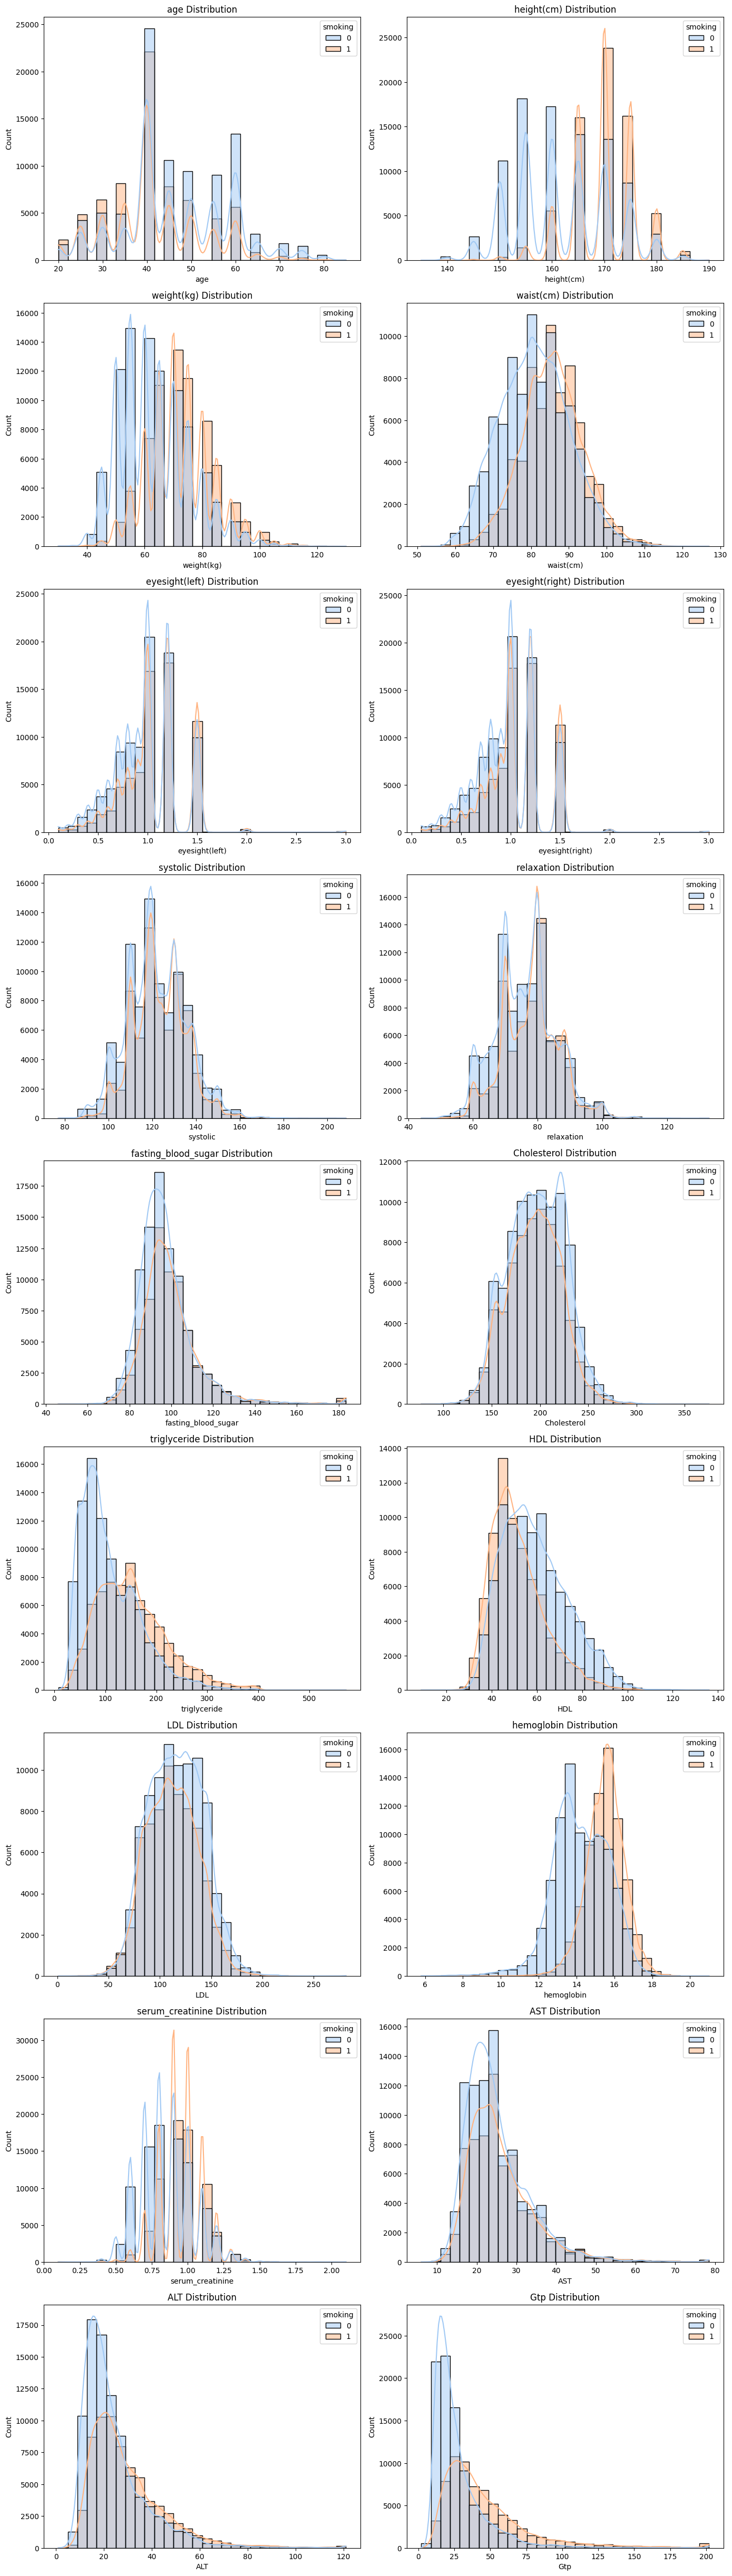

In [60]:
plt.figure(figsize=(14,len(num_cols)*3))
for idx,column in enumerate(num_cols):
    plt.subplot(len(num_cols)//2+1,2,idx+1)
    sns.histplot(x=column, hue="smoking", data=train,bins=30,kde=True, palette="pastel")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

In [61]:
scatter_fig = px.scatter(
    train,
    x="hemoglobin",
    y="Gtp",
    size="ALT",
    color="smoking",
    hover_name=train.index,
    log_x=True,
    size_max=60,
    title='Scatter Plot: Smoking Status, Hemoglobin, Gtp, and ALT',
)

scatter_fig.show()

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:150%; text-align:left;padding: 0px;">Feature Selection</p>

In [62]:

def filter_correlated_variables(dataframe, target_variable, high_threshold=0.9, low_threshold=0.1):
    cor_matrix = dataframe.corr().abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    to_drop_high = [column for column in upper_triangle_matrix.columns if any(upper_triangle_matrix[column] > high_threshold)]
    cor_with_target = dataframe.corrwith(dataframe[target_variable]).abs()
    to_drop_low = cor_with_target[cor_with_target < low_threshold].index.tolist()
    dataframe_filtered = dataframe.drop(to_drop_high + to_drop_low, axis=1)

    return dataframe_filtered, to_drop_low

In [63]:
train,to_drop_low  = filter_correlated_variables(train, target_variable='smoking', high_threshold=0.9, low_threshold=0.1)

In [64]:
to_drop_low

['hearing(left)',
 'hearing(right)',
 'systolic',
 'fasting_blood_sugar',
 'Cholesterol',
 'LDL',
 'Urine_protein',
 'AST']

In [65]:
train.shape

(159256, 15)

In [67]:
test = test.drop(to_drop_low, axis=1)
test.shape

(106171, 14)

<p style="background-color:#2E2E2E; font-family:'Courier New', monospace; color:#00FFFF; font-size:160%; text-align:center; padding: 10px; border-radius: 20px;"> 🛠️ Modeling 🤖 </p>


In [69]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scale_features(train_data, test_data):
    
    target_variable = 'smoking'  
    train_features = train_data.drop(columns=[target_variable])
    train_target = train_data[target_variable]

    if target_variable in test_data.columns:
        test_features = test_data.drop(columns=[target_variable])
    else:
        test_features = test_data

    scaler = MinMaxScaler()
    
    train_features_scaled = scaler.fit_transform(train_features)

    test_features_scaled = scaler.transform(test_features)

    train_features_scaled_df = pd.DataFrame(train_features_scaled, columns=train_features.columns)
    test_features_scaled_df = pd.DataFrame(test_features_scaled, columns=test_features.columns)

    train_scaled = pd.concat([train_features_scaled_df, train_target], axis=1)

    return train_scaled, test_features_scaled_df



In [70]:
train, test = min_max_scale_features(train_data=train, test_data=test)

In [71]:
train.head()

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0  0.538462    0.545455        0.30   0.394737        0.137931   
1  0.769231    0.545455        0.35   0.500000        0.172414   
2  0.000000    0.636364        0.45   0.394737        0.103448   
3  0.230769    0.818182        0.65   0.710526        0.482759   
4  0.153846    0.545455        0.30   0.388158        0.482759   

   eyesight(right)  relaxation  triglyceride       HDL  hemoglobin  \
0         0.172414    0.483146      0.518190  0.244094    0.703947   
1         0.206897    0.438202      0.083407  0.377953    0.684211   
2         0.137931    0.348315      0.335404  0.283465    0.763158   
3         0.379310    0.494382      0.346051  0.228346    0.664474   
4         0.310345    0.359551      0.140195  0.275591    0.631579   

   serum_creatinine       ALT    Gtp  dental_caries  smoking  
0              0.45  0.200000  0.125            0.0        1  
1              0.50  0.183333  0.175            1.0        0  
2              0.35  0.250000  0.255            0.0        1  
3              0.45  0.216667  0.140            1.0        0  
4              0.35  0.100000  0.075            0.0        1

In [72]:
test.head()

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0  0.307692    0.545455        0.40   0.434211        0.379310   
1  0.923077    0.454545        0.30   0.552632        0.310345   
2  0.615385    0.636364        0.40   0.467105        0.172414   
3  0.307692    0.454545        0.20   0.210526        0.068966   
4  0.307692    0.636364        0.45   0.505263        0.310345   

   eyesight(right)  relaxation  triglyceride       HDL  hemoglobin  \
0         0.379310    0.505618      0.315883  0.314961    0.552632   
1         0.310345    0.314607      0.266193  0.204724    0.473684   
2         0.206897    0.348315      0.292813  0.236220    0.631579   
3         0.103448    0.202247      0.069210  0.519685    0.572368   
4         0.275862    0.561798      0.163265  0.236220    0.703947   

   serum_creatinine       ALT    Gtp  dental_caries  
0              0.40  0.200000  0.150            0.0  
1              0.50  0.091667  0.110            0.0  
2              0.65  0.491667  0.170            0.0  
3              0.25  0.141667  0.040            1.0  
4              0.45  0.316667  0.125            1.0

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
X = train.drop("smoking", axis=1)
y = train["smoking"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1, random_state = 6)

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:150%; text-align:left;padding: 0px;">LightGBM Classifier</p>

0.8583488075059991

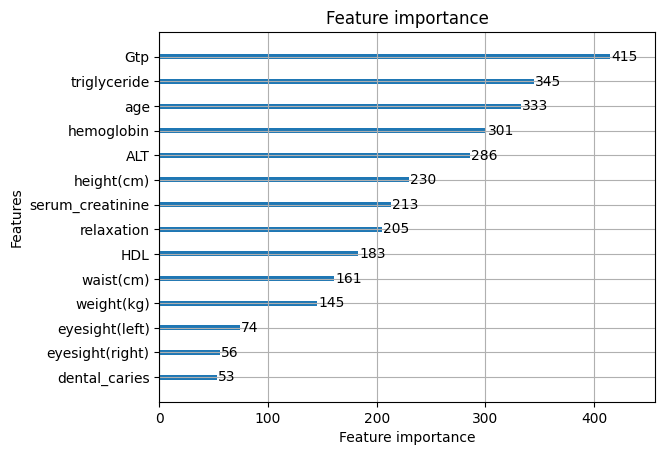

In [74]:
import lightgbm
lgb = lightgbm.LGBMClassifier(metric = "auc")
lgb.fit(X_train, y_train)
lightgbm.plot_importance(lgb);
roc_auc_score(y_test,lgb.predict_proba(X_test)[:,1])

In [77]:
lgbm_params = {"metric":['auc'],
               "max_depth": [1, 10],
               "learning_rate": [0.01, 0.5],
               "n_estimators": [400, 700],
               "colsample_bytree": [0.1, 1]}

In [84]:
lgbm_best_grid = GridSearchCV(lgb, lgbm_params, cv=3, n_jobs=-1, verbose=True).fit(X, y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [85]:
lgbm_final = lgb.set_params(**lgbm_best_grid.best_params_, random_state=6).fit(X, y)

In [86]:
cv_results_lgb = cross_validate(lgbm_final, X, y, cv=5, scoring=["roc_auc"])

In [87]:
cv_results_lgb['test_roc_auc'].mean()

0.8590793920913853

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:150%; text-align:left;padding: 0px;">XGBoost Classifier</p>

0.859903049823961

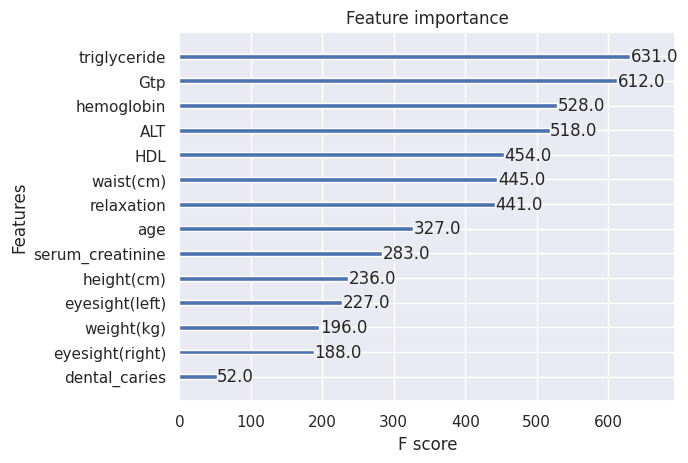

In [89]:
import xgboost
xgb = xgboost.XGBClassifier(eval_metric="auc")
xgb.fit(X_train, y_train)
xgboost.plot_importance(xgb);
roc_auc_score(y_test,xgb.predict_proba(X_test)[:,1])

In [91]:
xgb_params = {"max_depth": [1, 10],
              "learning_rate": [0.01, 0.5],
              "n_estimators": [500, 1000],
              "eval_metric":['auc']}

In [92]:
xbg_best_grid = GridSearchCV(xgb, xgb_params, cv=3, n_jobs=-1, verbose=True).fit(X, y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [93]:
xgb_final = xgb.set_params(**xbg_best_grid.best_params_, random_state=6).fit(X, y)

In [94]:
cv_results_xgb = cross_validate(xgb_final, X, y, cv=5, scoring=["roc_auc"])

In [95]:
cv_results_xgb['test_roc_auc'].mean()

0.8603945002595454

In [96]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[
                                      ('lgbm', lgbm_final), 
                                      ('xgb', xgb_final)], voting='soft')
voting.fit(X_train,y_train)
voting_pred = voting.predict_proba(X_test)[:,1]

print('Accuracy: ', roc_auc_score(y_test, voting_pred))

Accuracy:  0.859543121966466


<p style="background-color:#2E2E2E; font-family:'Courier New', monospace; color:#00FFFF; font-size:160%; text-align:center; padding: 10px; border-radius: 20px;"> 🎯 Prediction 🤖 </p>


In [97]:
sub["smoking"]=voting.predict_proba(test)[:, 1]
sub.to_csv('submission.csv',index=False)
sub

id   smoking
0       159256  0.591396
1       159257  0.245310
2       159258  0.438438
3       159259  0.029630
4       159260  0.562318
...        ...       ...
106166  265422  0.519537
106167  265423  0.589122
106168  265424  0.492381
106169  265425  0.101216
106170  265426  0.027712

[106171 rows x 2 columns]